# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

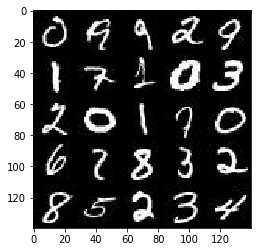

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

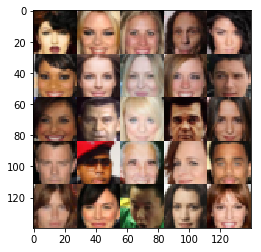

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real_images = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels],
                                       name='input_real_images')
    z_data = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='z_data')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return input_real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        leaky_relu_1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(leaky_relu_1, 128, 5, strides=2, padding='same')
        batch_norm_2 = tf.layers.batch_normalization(x2, training=True)
        leaky_relu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        x3 = tf.layers.conv2d(leaky_relu_2, 256, 5, strides=2, padding='same')
        batch_norm_3 = tf.layers.batch_normalization(x3, training=True)
        leaky_relu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        FC = tf.reshape(leaky_relu_3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(FC, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse = not is_train):
        FC = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(FC, (-1, 2, 2, 512))
        batch_norm_1 = tf.layers.batch_normalization(x1, training=is_train)
        leaky_relu_1 = tf.maximum(alpha * batch_norm_1, batch_norm_1)
    
        x2 = tf.layers.conv2d_transpose(leaky_relu_1, 256, 5, strides=2, padding='valid')
        batch_norm_2 = tf.layers.batch_normalization(x2, training=is_train)
        leaky_relu_2 = tf.maximum(alpha * batch_norm_2, batch_norm_2)
        
        x3 = tf.layers.conv2d_transpose(leaky_relu_2, 128, 5, strides=2, padding='same')
        batch_norm_3 = tf.layers.batch_normalization(x3, training=is_train)
        leaky_relu_3 = tf.maximum(alpha * batch_norm_3, batch_norm_3)
        
        x4 = tf.layers.conv2d_transpose(leaky_relu_3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(x4)
        
    return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_output = generator(input_z, out_channel_dim)
    
    discriminator_output_real, discriminator_logits_real = discriminator(input_real)
    discriminator_output_fake, discriminator_logits_fake = discriminator(generator_output, reuse=True)
    
    #calculating total discriminator loss as the sum of losses for fake and real examples
    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real,
                                                                                     labels=tf.ones_like(discriminator_logits_real)*0.9))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,
                                                                                     labels=tf.zeros_like(discriminator_logits_fake)))
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    #calculating generator loss
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake,
                                                                            labels=tf.ones_like(discriminator_logits_fake)))
    
    #returning the results
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [op for op in update_ops if op.name.startswith('generator')]
    d_updates = [op for op in update_ops if op.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_updates):
        d_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(g_updates):
        g_train_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_optimizer, g_train_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 3.9714
Epoch 1/2... Discriminator Loss: 3.2301... Generator Loss: 0.1482
Epoch 1/2... Discriminator Loss: 1.9021... Generator Loss: 7.7422
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 3.5651


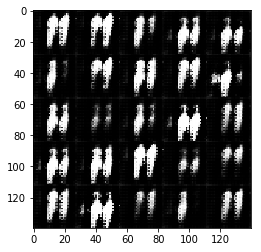

Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 3.7167
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.7395
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 2.9964


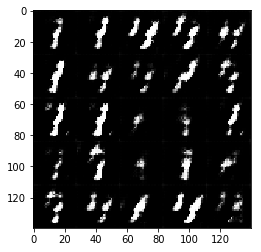

Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 4.6961
Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 2.3869
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 3.9463


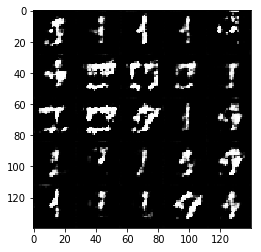

Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 4.5328
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.1687


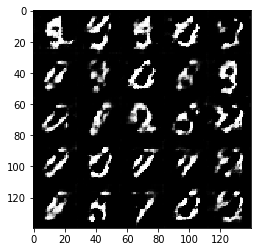

Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 2.1973
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.6013
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.9745


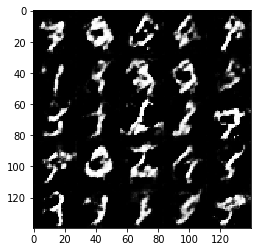

Epoch 1/2... Discriminator Loss: 0.7217... Generator Loss: 2.0737
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 1.2363
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.6744
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.7106


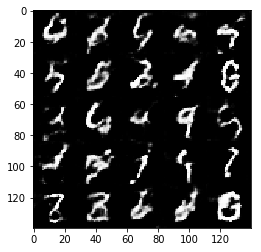

Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.4232
Epoch 1/2... Discriminator Loss: 1.0781... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.5966... Generator Loss: 3.7147


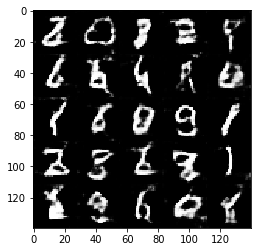

Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.7754
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 1.7708... Generator Loss: 0.3569


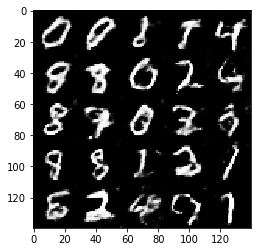

Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.0143
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 1.5505


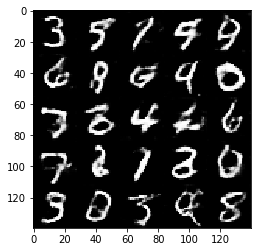

Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 2.1542
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.8671


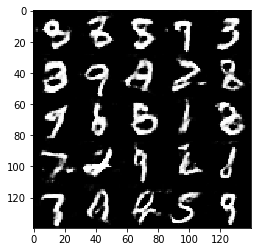

Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 1.9306
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.1677
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.7336


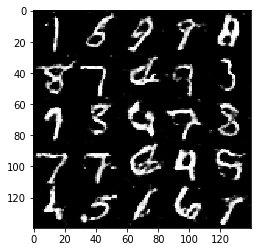

Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.4701
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.2624
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.0385


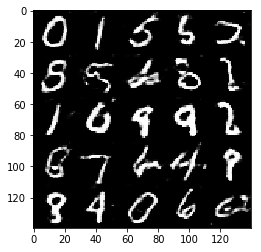

Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.8372
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.5765


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 8.5324
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 5.3257
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 3.0033
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 2.4981


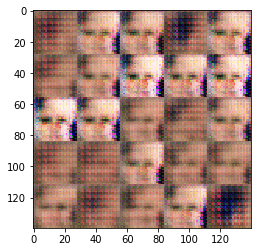

Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 4.1797
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 2.1040


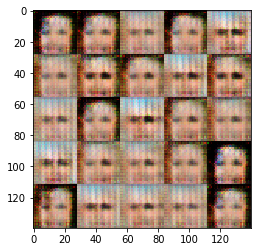

Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 3.5945
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 2.7031


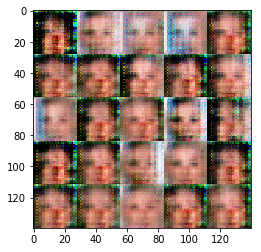

Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5152


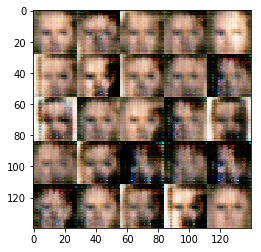

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 2.2719... Generator Loss: 3.5351
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.6003
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.7891


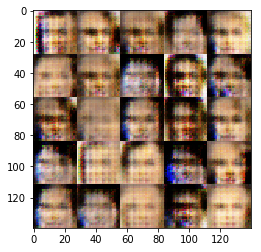

Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 2.2822
Epoch 1/1... Discriminator Loss: 1.7121... Generator Loss: 3.0024
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 2.3673


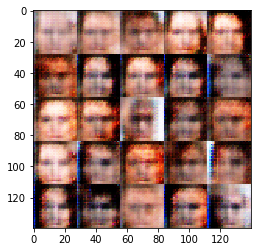

Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 2.1133... Generator Loss: 3.5604
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.7021


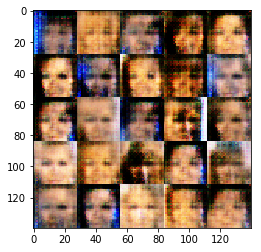

Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 2.4170
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6476


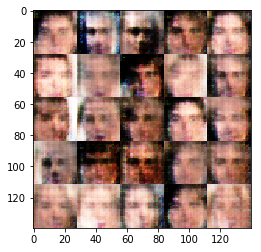

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.9822
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.1955


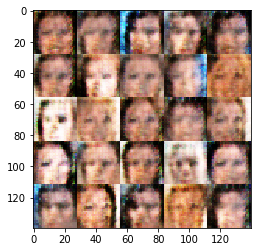

Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.1127


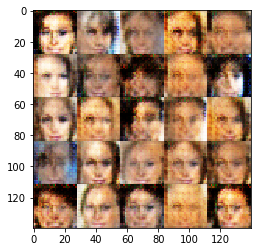

Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.9567... Generator Loss: 3.0572
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9133


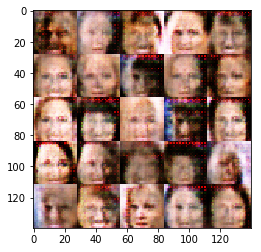

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.1125


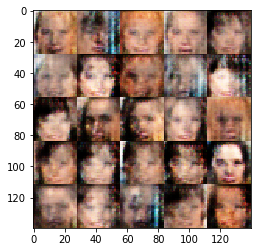

Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.4708
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.4987
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.4432


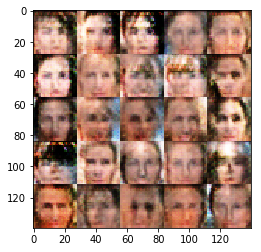

Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 2.3009
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1834
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.9296


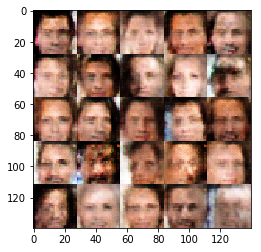

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.8595


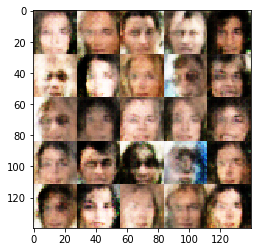

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 2.2355
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.5916


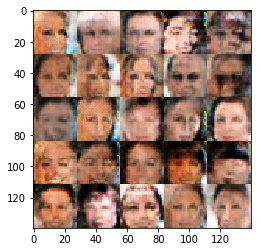

Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 2.7315
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8786


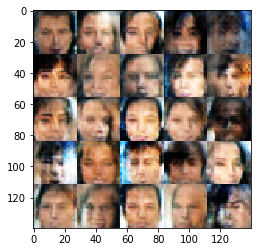

Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.1994


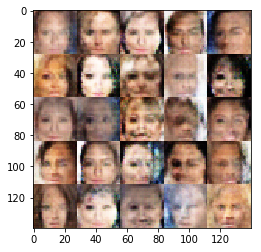

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 2.2720
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.2755


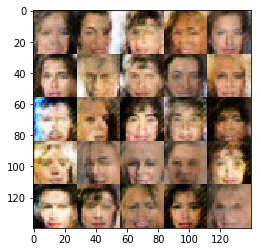

Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9177


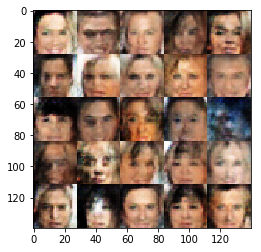

Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8541


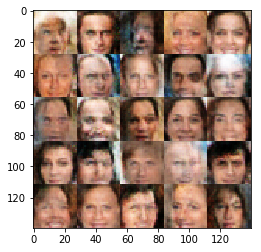

Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.5865
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.2709


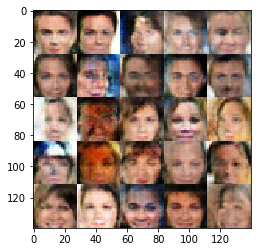

Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 1.5219
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 1.9210


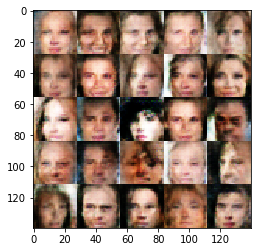

Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.4185


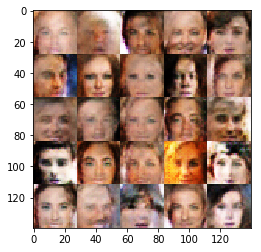

Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6871


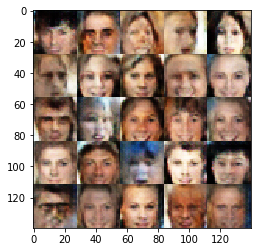

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8411


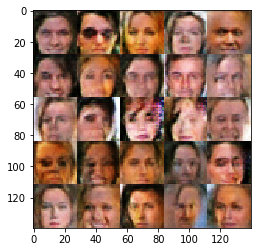

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.4239


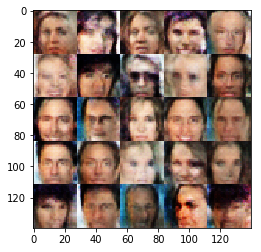

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5283


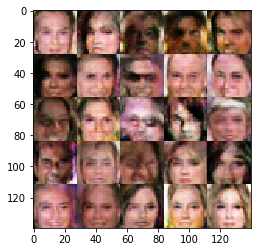

Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7385


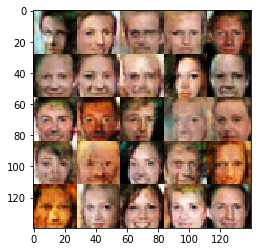

Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5400


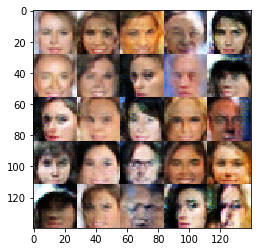

Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.4093


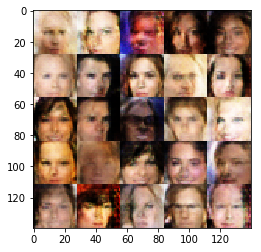

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.8275


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.